<h2>Libraries</h2>

In [36]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import librosa
import scipy.signal as signal
from scipy.signal import stft, istft
import numpy as np
from IPython.display import Audio
import librosa.display
import matplotlib.pyplot as plt
import os
import glob
import re
import pyloudnorm as pyln
import seaborn as sns

In [14]:
import os
import re

def find_files_with_eight_digits(directory):
    ID_pattern = re.compile(r'\d{9}')  # الگوی پیدا کردن 8 عدد پشت سر هم
    gender_pattern = re.compile(r'male|female|Male|Female|MALE|FEMAIL')  # الگوی پیدا کردن F یا M
    for filename in os.listdir(directory):
        match = ID_pattern.search(filename)
        if match:
            print(f"Found Numbers: {match.group()}")
        else:
            print("DUMB")
            print(f"Numbers not found in {filename}")
        gender_match = gender_pattern.search(filename)
        if gender_match:
            if gender_match.group() == 'male' or gender_match.group() == 'Male' or gender_match.group() == 'MALE':
                gender = 0
            elif gender_match.group() == 'female' or gender_match.group() == 'Female' or gender_match.group() == 'FEMALE':
                gender = 1
            else:
                gender = None
            print(gender)
        else:
            print("fucked up")
            print(filename)

# مثال: پوشه‌ی جاری را بررسی می‌کند
find_files_with_eight_digits(r"C:\Users\hnoro\OneDrive\Documents\MLP\HW1_M")

Found Numbers: 810103226
0
Found Numbers: 810801075
0
Found Numbers: 810101423
0
Found Numbers: 810103241
0
Found Numbers: 810103317
0
Found Numbers: 810103322
0
Found Numbers: 151501033
0
Found Numbers: 159403005
0
Found Numbers: 610300017
0
Found Numbers: 610300032
0
Found Numbers: 610300070
1
Found Numbers: 610399182
0
Found Numbers: 610399205
0
Found Numbers: 610399206
0
Found Numbers: 810100075
1
Found Numbers: 810100091
0
Found Numbers: 810100107
0
Found Numbers: 810100130
0
Found Numbers: 810100135
1
Found Numbers: 810100150
0
Found Numbers: 810100168
1
Found Numbers: 810100193
1
Found Numbers: 810100198
0
Found Numbers: 810100222
1
Found Numbers: 810100261
0
Found Numbers: 810100268
1
Found Numbers: 810100269
0
Found Numbers: 810100270
0
Found Numbers: 810100590
1
Found Numbers: 810101401
0
Found Numbers: 810101413
0
Found Numbers: 810101419
0
Found Numbers: 810101420
0
Found Numbers: 810101456
1
Found Numbers: 810101465
0
Found Numbers: 810101471
1
Found Numbers: 810101503
0
F

<h2>Import audio</h2>

In [19]:
file_path = r"C:\Users\hnoro\OneDrive\Documents\MLP\HW1_M\HW1.Q1.810102087_female.mp3"
audio, sr = librosa.load(file_path, sr = 22500)
Audio(file_path)

C:\Users\hnoro\AppData\Local\Temp\ipykernel_9380\3127114766.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr = 22500)
C:\Users\hnoro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\hnoro\\OneDrive\\Documents\\MLP\\HW1_M\\HW1.Q1.810102087_female.mp3'

<h2>Resampling and Skip silence</h2>

`target_sr` is target sample rate `top_db` is silence threshol

In [22]:
import IPython.display as ipd
def skip_silence(audio):
  non_silent_intervals = librosa.effects.split(audio, top_db = 30, frame_length = 2048, hop_length = 512)
  non_silent_audio = np.concatenate([audio[start:end] for start, end in non_silent_intervals])
  return non_silent_audio

audio = skip_silence(audio)
ipd.Audio(audio, rate = 22500)

In [13]:
segment_samples = 5 * sr
num_segments = len(audio) // segment_samples
segments = [audio[i * segment_samples : (i + 1) * segment_samples] for i in range(num_segments)]
ipd.Audio(segments[12], rate = 22500)


<h2>Noise Reduction</h2>

<h3>spectral subtraction</h3>

In [20]:
def spectral_subtraction(noisy_audio, sr = 22050, noise_start = 0, noise_end = 1):
    f, t, Zxx = stft(noisy_audio, fs=sr, nperseg=1024)

    noise_idx = (t >= noise_start) & (t <= noise_end)
    noise_spectrum = np.mean(np.abs(Zxx[:, noise_idx]), axis=1, keepdims=True)

    magnitude = np.abs(Zxx) - noise_spectrum
    magnitude = np.maximum(magnitude, 0)

    Zxx_denoised = magnitude * np.exp(1j * np.angle(Zxx))

    _, denoised_audio = istft(Zxx_denoised, fs=sr, nperseg=1024)

    return denoised_audio

#denoised_audio = spectral_subtraction(audio, sr, noise_start=0, noise_end=1)
#Audio(denoised_audio, rate=sr)

<h2>Normalizing</h2>

In [ ]:
denoised_audio = denoised_audio / np.max(np.abs(denoised_audio))

<h2>Windowing</h2>

In [ ]:
window_size = int(sr * 0.02)
step_size = int(sr * 0.01)

frames = [denoised_audio[i:i + window_size] for i in range(0, len(denoised_audio) - window_size, step_size)]

frames = np.array(frames)
print(f"Frames shape: {frames.shape}")

Frames shape: (1806, 400)


MFCCs shape: (13, 707)


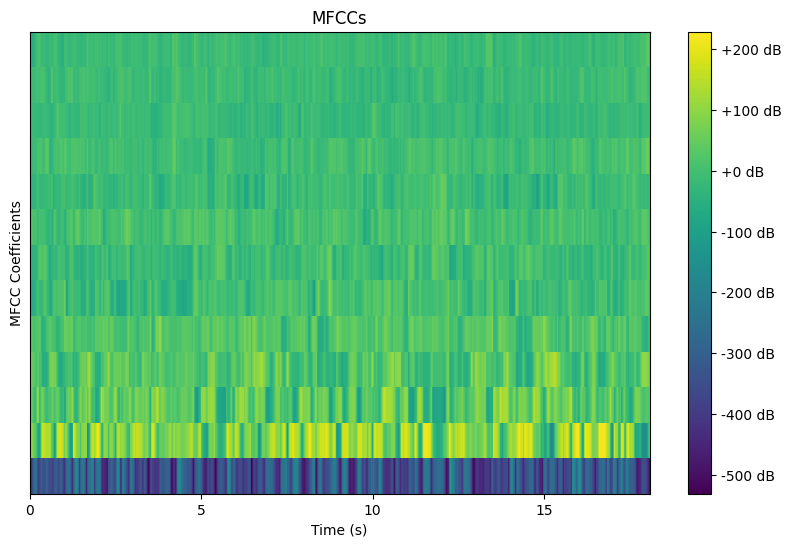

In [ ]:
n_mfcc = 13
mfccs = librosa.feature.mfcc(y=denoised_audio, sr=sr, n_mfcc=n_mfcc)

print(f"MFCCs shape: {mfccs.shape}")

plt.figure(figsize=(10, 6))
librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCCs')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficients')
plt.show()

Log-Mel Spectrogram shape: (128, 707)


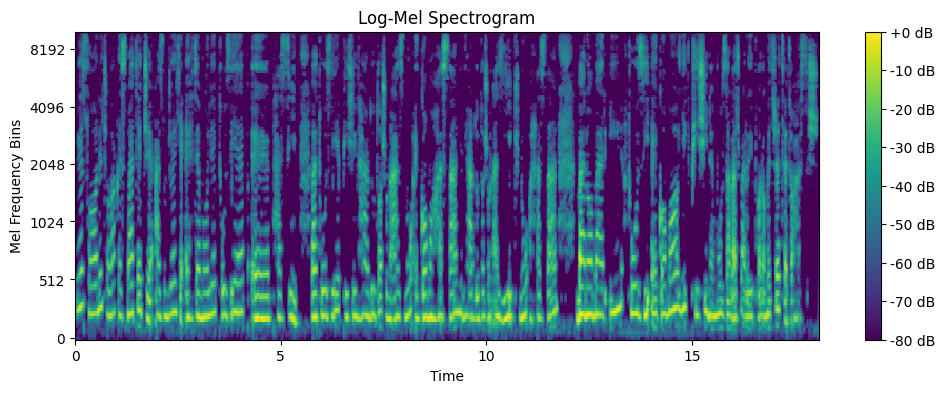

In [ ]:
n_mels = 128
n_fft = 2048
hop_length = 512

mel_spec = librosa.feature.melspectrogram(y=denoised_audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)

log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

print(f"Log-Mel Spectrogram shape: {log_mel_spec.shape}")
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_mel_spec, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bins')
plt.show()

Spectral Centroid shape: (1, 707)


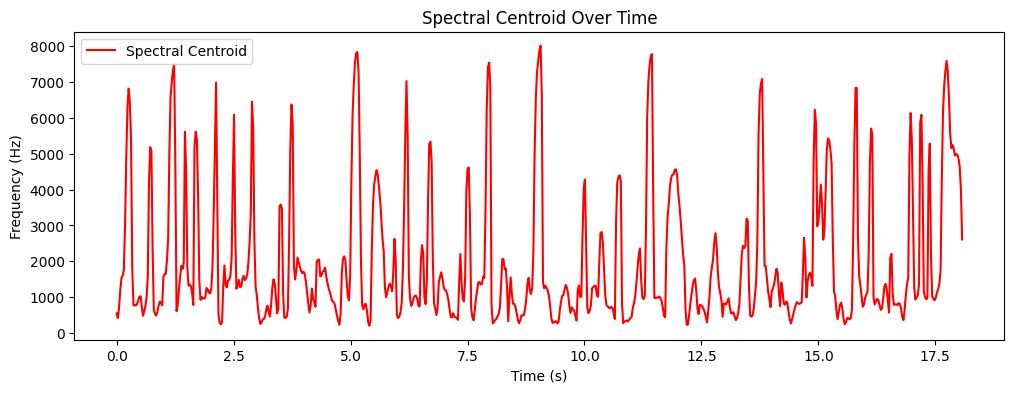

In [ ]:
spectral_centroid = librosa.feature.spectral_centroid(y=denoised_audio, sr=sr, n_fft=2048, hop_length=512)

print(f"Spectral Centroid shape: {spectral_centroid.shape}")
plt.figure(figsize=(12, 4))
frames = range(spectral_centroid.shape[1])
times = librosa.frames_to_time(frames, sr=sr, hop_length=512)

plt.plot(times, spectral_centroid.T, label="Spectral Centroid", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectral Centroid Over Time")
plt.legend()
plt.show()

Spectral Bandwidth shape: (1, 707)


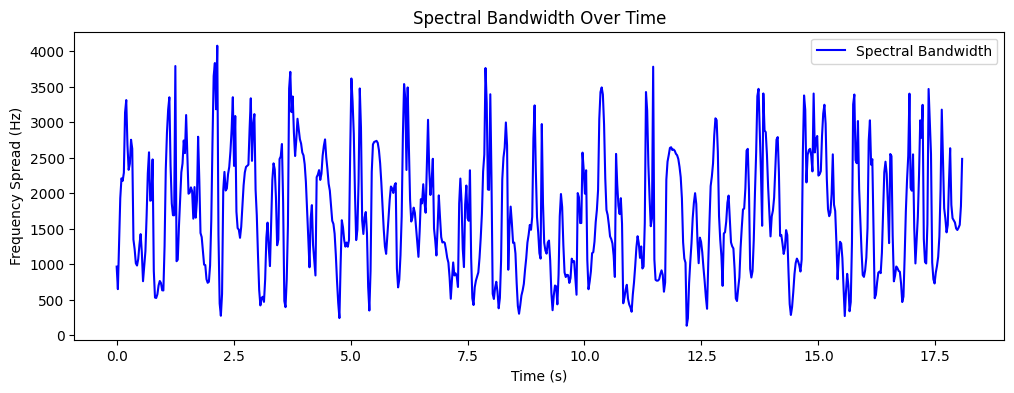

In [ ]:
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=denoised_audio, sr=sr, n_fft=2048, hop_length=512)

print(f"Spectral Bandwidth shape: {spectral_bandwidth.shape}")
plt.figure(figsize=(12, 4))
frames = range(spectral_bandwidth.shape[1])
times = librosa.frames_to_time(frames, sr=sr, hop_length=512)

plt.plot(times, spectral_bandwidth.T, label="Spectral Bandwidth", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Frequency Spread (Hz)")
plt.title("Spectral Bandwidth Over Time")
plt.legend()
plt.show()

Spectral Contrast shape: (7, 707)


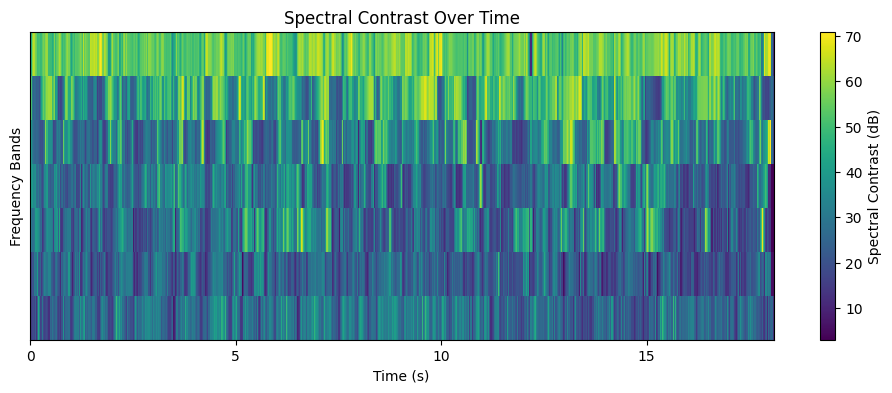

In [ ]:
n_bands = 6
spectral_contrast = librosa.feature.spectral_contrast(y=denoised_audio, sr=sr, n_fft=2048, hop_length=512, fmin=200.0, n_bands=n_bands)

print(f"Spectral Contrast shape: {spectral_contrast.shape}")
plt.figure(figsize=(12, 4))
librosa.display.specshow(spectral_contrast, x_axis='time', sr=sr, hop_length=512, cmap='viridis')
plt.colorbar(label="Spectral Contrast (dB)")
plt.title("Spectral Contrast Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Frequency Bands")
plt.show()


Zero-Crossing Rate shape: (1, 707)


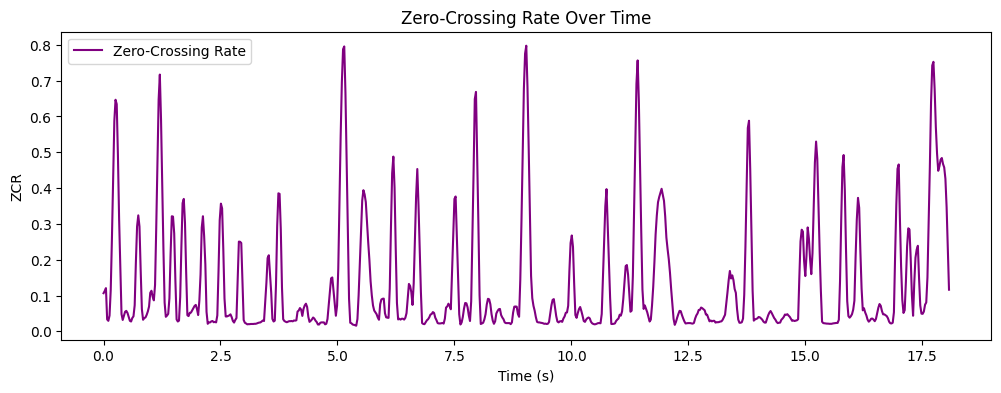

In [ ]:
zcr = librosa.feature.zero_crossing_rate(denoised_audio, frame_length=2048, hop_length=512)

print(f"Zero-Crossing Rate shape: {zcr.shape}")
plt.figure(figsize=(12, 4))
frames = range(zcr.shape[1])
times = librosa.frames_to_time(frames, sr=sr, hop_length=512)
plt.plot(times, zcr.T, label="Zero-Crossing Rate", color="purple")
plt.xlabel("Time (s)")
plt.ylabel("ZCR")
plt.title("Zero-Crossing Rate Over Time")
plt.legend()
plt.show()


Energy shape: (702,)


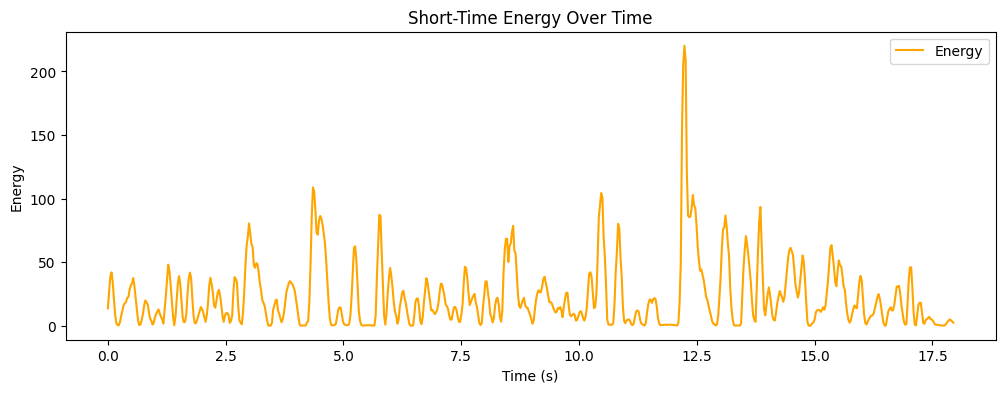

In [ ]:
frame_length = 2048
hop_length = 512

energy = np.array([
    np.sum(np.abs(denoised_audio[i:i + frame_length])**2)
    for i in range(0, len(denoised_audio) - frame_length, hop_length)
])

print(f"Energy shape: {energy.shape}")
plt.figure(figsize=(12, 4))
times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)

plt.plot(times, energy, label="Energy", color="orange")
plt.xlabel("Time (s)")
plt.ylabel("Energy")
plt.title("Short-Time Energy Over Time")
plt.legend()
plt.show()


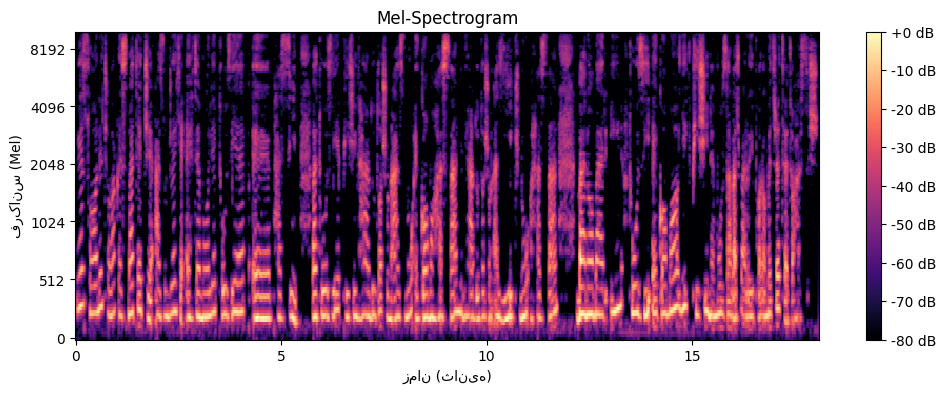

In [ ]:
n_mels = 128
mel_spectrogram = librosa.feature.melspectrogram(y=denoised_audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel-Spectrogram")
plt.xlabel("زمان (ثانیه)")
plt.ylabel("فرکانس (Mel)")
plt.show()

In [39]:
audio_folder = "/content/drive/My Drive/HW1_M/"
audio_files = glob.glob(os.path.join(audio_folder, "*.mp3"))
def resample(audio , sr):
    target_sr = 20000
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    non_silent_intervals = librosa.effects.split(audio, top_db=30)

    non_silent_audio = np.concatenate([audio[start:end] for start, end in non_silent_intervals])
    return non_silent_audio, sr

# List to store extracted features
features = []
print(len(audio_files))
n = 50

0


In [17]:
def split_audio(audio, segment_length = 3, sr = 22050):
    segment_samples = segment_length * sr
    num_segments = len(audio) // segment_samples
    segments = [audio[i * segment_samples : (i + 1) * segment_samples] for i in range(num_segments)]
    return segments

In [16]:
def find_label(filename):
    ID_pattern = re.compile(r'\d{8}')
    gender_pattern = re.compile(r'male|female|Male|Female|MALE|FEMAIL')
    ID_match = ID_pattern.search(filename)
    gender_match = gender_pattern.search(filename)
    if gender_match.group() == 'male' or gender_match.group() == 'Male' or gender_match.group() == 'MALE':
        gender = 0
    elif gender_match.group() == 'female' or gender_match.group() == 'Female' or gender_match.group() == 'FEMALE':
        gender = 1
    else:
        gender = None
    if ID_match and gender_match and gender != None:
        return ID_match.group(), gender

In [15]:
def loudness_normalization(audio, sr = 22050):
    meter = pyln.Meter(sr)
    loudness = meter.integrated_loudness(audio)
    target_loudness = -23.0
    gain = 10**((target_loudness - loudness) / 20.0)
    audio_normalized = audio * gain
    return audio_normalized

In [51]:
folder_path = r"C:\Users\hnoro\OneDrive\Documents\MLP\HW1_M"
features = []
ID_labels = []
gender_labels = []
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    audio_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
    i = 0
    for file in audio_files:
        i += 1
        if i % 10 == 0:
            print(i)
        ID_label, gender_label = find_label(file)
        audio, sr = librosa.load(file, sr = 22050)
        audio = skip_silence(audio)
        audio = spectral_subtraction(audio)
        audio = loudness_normalization(audio)
        segments = split_audio(audio)
        for segment in segments:
            mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13), axis=1)
            log_mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128), axis=1)  # Log Mel-Spectrogram (128 values)
            spec_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr), axis=1)  # Spectral Centroid (1 value)
            spec_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr), axis=1)  # Spectral Bandwidth (1 value)
            spec_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr), axis=1)  # Spectral Contrast (7 values)
            zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio), axis=1)  # Zero-Crossing Rate (1 value)
            energy = np.mean(np.square(audio))  # Energy (1 value)
            feature_vector = np.hstack([mfcc, log_mel, spec_centroid, spec_bandwidth, spec_contrast, zcr, energy])
            features.append(feature_vector)
            ID_labels.append(ID_label)
            gender_labels.append(gender_label)

    else:
        print(f"Folder {folder_path} not found.")

10
20
30
40
50
60
70
80
90
100
Folder C:\Users\hnoro\OneDrive\Documents\MLP\HW1_M not found.


In [33]:
print(len(features))
print(features[0])

427
[-3.71702979e+02  4.56540892e+01  7.77065314e+01  2.45234894e+01
  3.67654512e+01  2.15071971e+01 -1.19396551e+01 -6.56478064e+00
 -1.07274809e+01 -1.69328238e+01 -1.90183731e+01 -5.62194468e+00
  9.33204758e-01  6.63167727e-03  4.18342948e-02  2.88387421e-01
  1.83055635e+00  1.45425883e+00  1.13326616e+00  1.50273993e+00
  5.00752195e+00  2.94731403e+00  1.98837493e+00  1.35546642e+00
  3.40815565e+00  1.52538676e+01  1.80440219e+01  4.09398371e+00
  4.02989307e+00  2.71716763e+00  7.02547639e+00  7.19731752e+00
  5.77249856e+00  3.05180670e+00  2.10572708e+00  1.68943872e+00
  1.60930741e+00  1.05756095e+00  7.54396588e-01  5.90693668e-01
  2.51403683e-01  1.97813049e-01  2.42570687e-01  8.69372163e-02
  1.01156536e-01  1.26272649e-01  8.59322068e-02  1.53457189e-01
  1.60948045e-01  2.44617049e-01  3.35758104e-01  2.18802786e-01
  3.63050441e-01  3.67993859e-01  4.36633392e-01  3.14214365e-01
  3.08606699e-01  1.56674862e-01  9.12109816e-02  1.18294093e-01
  1.21207913e-01  1.4

In [40]:
for it in range(n):
    # Load audio file
    print(it)
    audio, sr = librosa.load(audio_files[it], sr=None)
    audio , sr = resample(audio, sr)
    audio = spectral_subtraction(audio , sr)
    audio = audio / np.max(np.abs(audio))
    audio, _ = librosa.effects.trim(audio, top_db=20)
    # Extract Features
    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13), axis=1)
    log_mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128), axis=1)  # Log Mel-Spectrogram (128 values)
    spec_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr), axis=1)  # Spectral Centroid (1 value)
    spec_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr), axis=1)  # Spectral Bandwidth (1 value)
    spec_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr), axis=1)  # Spectral Contrast (7 values)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=audio), axis=1)  # Zero-Crossing Rate (1 value)
    energy = np.mean(np.square(audio))  # Energy (1 value)

    # Concatenate all features into a single feature vector
    feature_vector = np.hstack([mfcc, log_mel, spec_centroid, spec_bandwidth, spec_contrast, zcr, energy])

    # Append to feature list
    features.append(feature_vector)

# Convert feature list to numpy array
features = np.array(features)
print(f"Feature Matrix Shape: {features.shape}")

0


IndexError: list index out of range

427


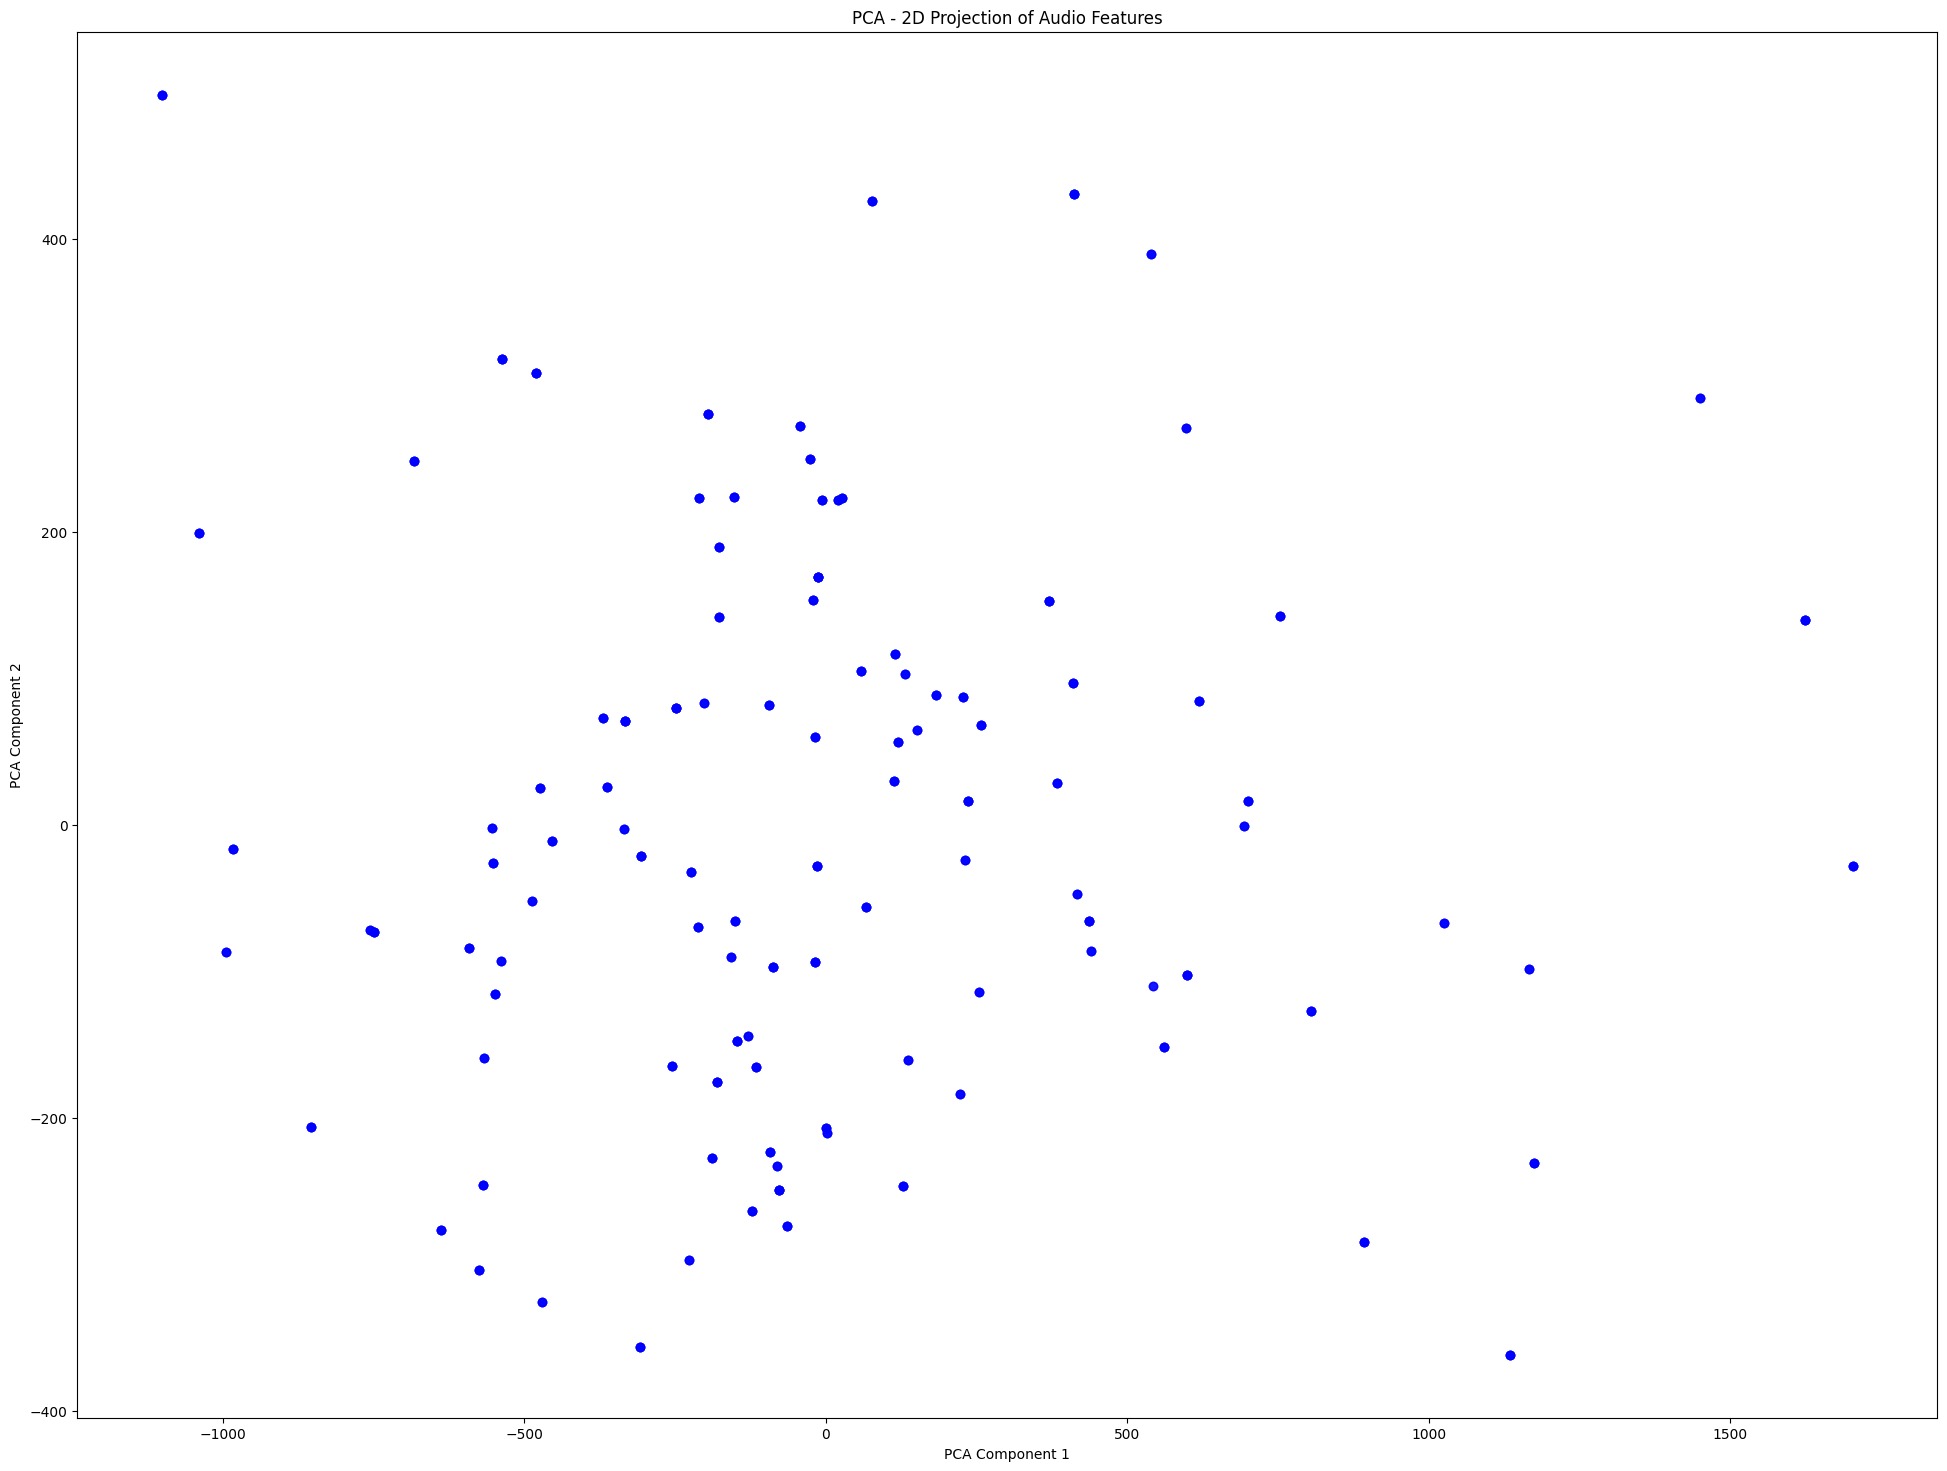

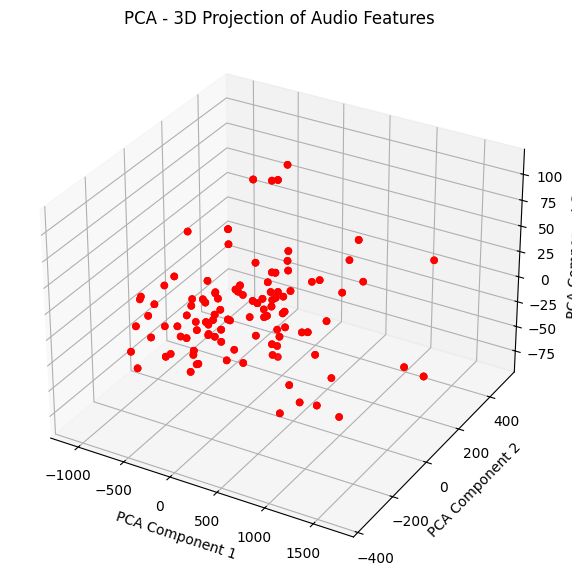

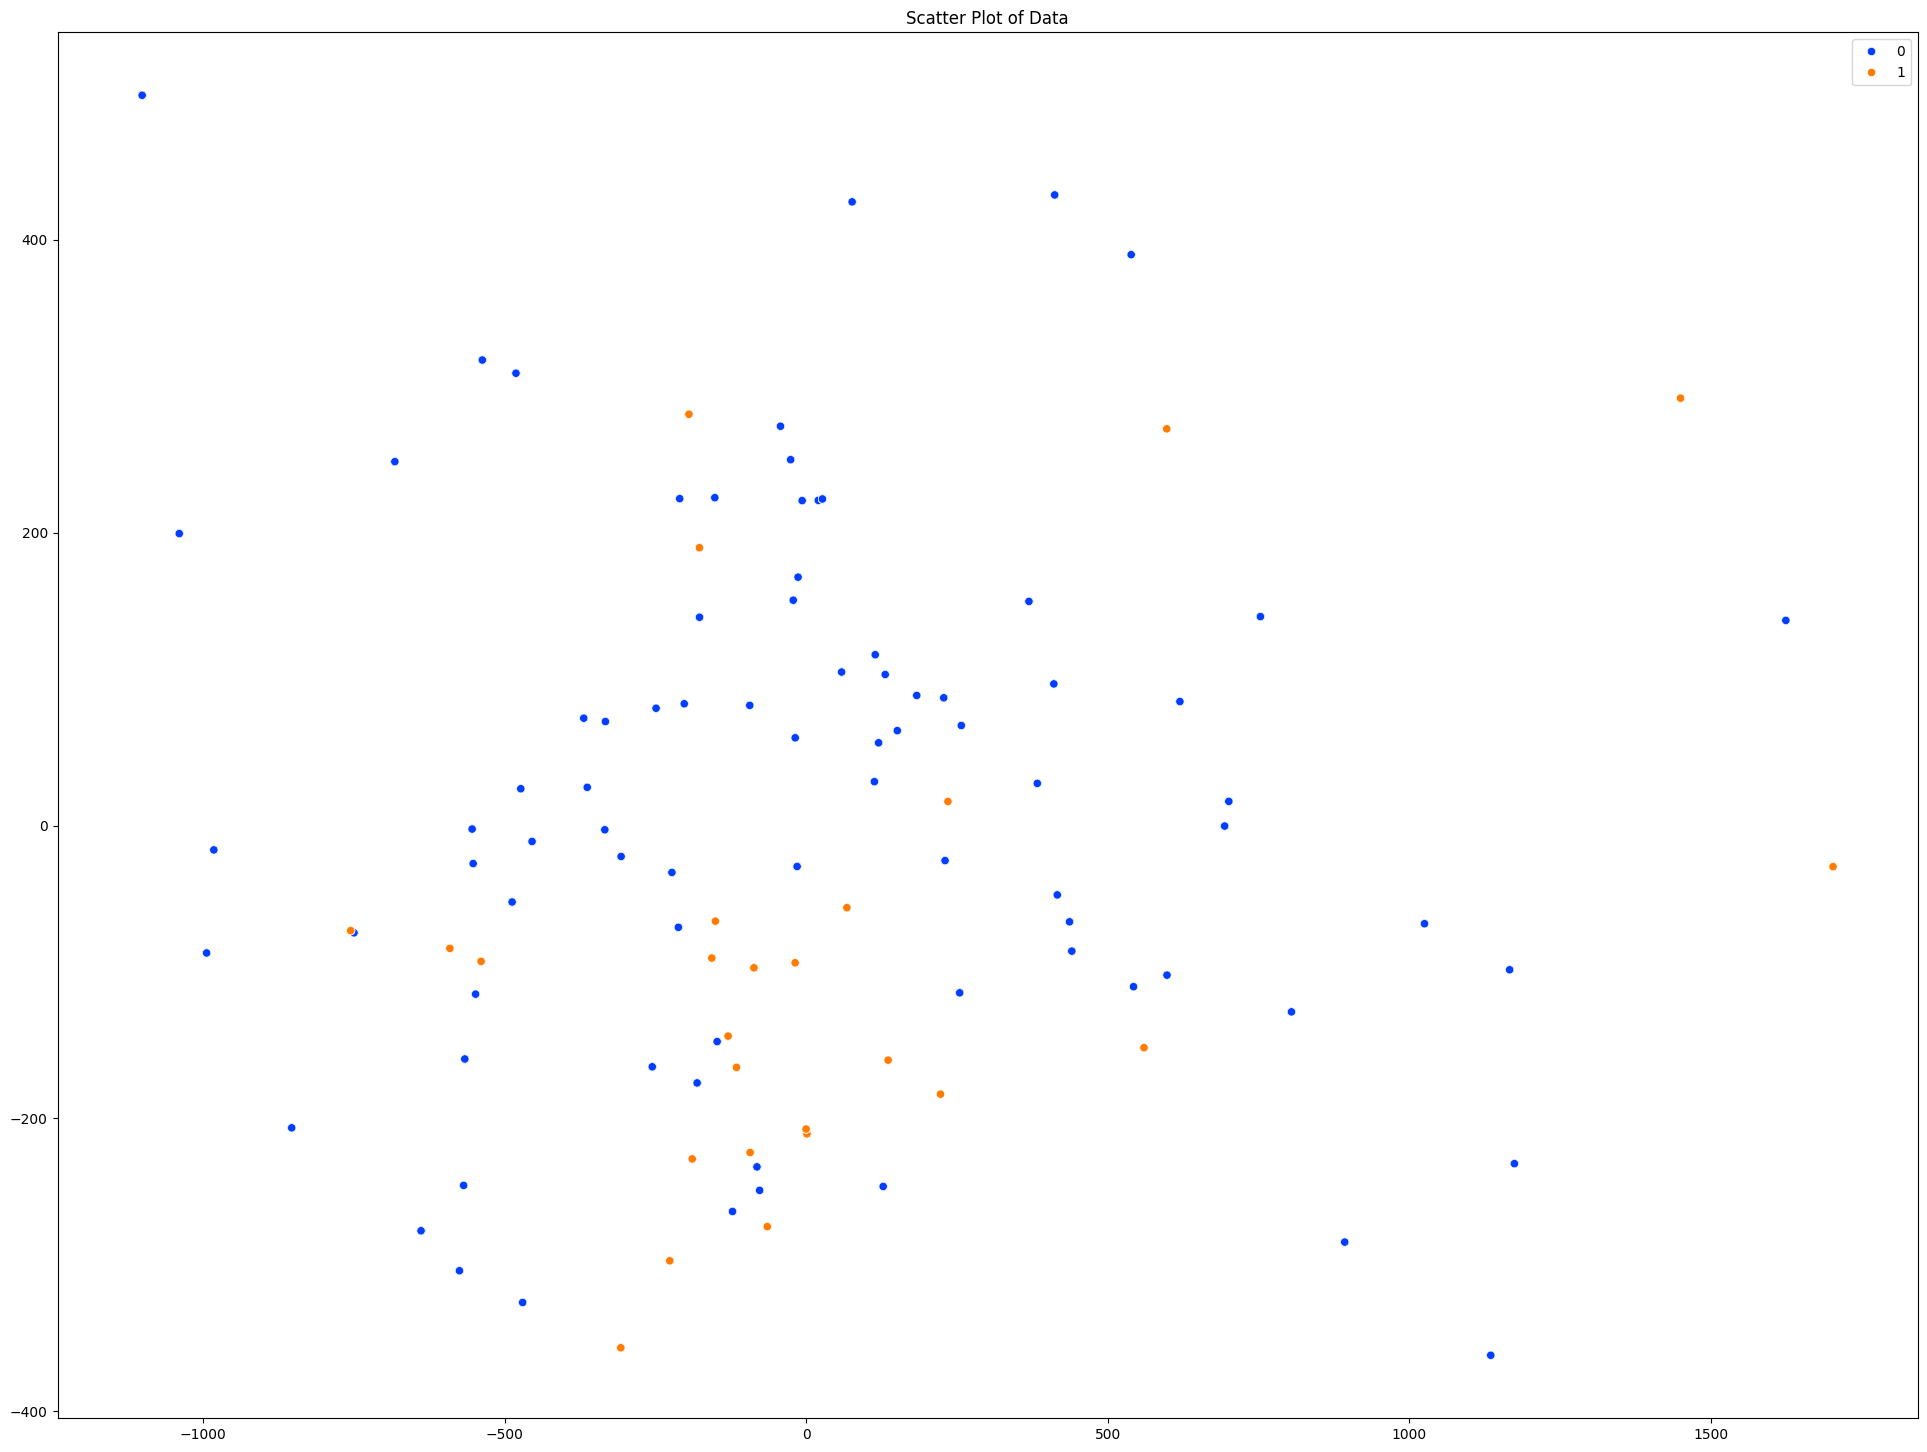

In [52]:
pca_2d = PCA(n_components=2)
features_2d = pca_2d.fit_transform(features)
print(len(features_2d))

# Plot PCA 2D
plt.figure(figsize=(24, 18))
plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.7, color="blue")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA - 2D Projection of Audio Features")
plt.show()


pca_3d = PCA(n_components=3)
features_3d = pca_3d.fit_transform(features)

# Plot PCA 3D
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], alpha=0.7, color="red")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.set_title("PCA - 3D Projection of Audio Features")
plt.show()
import pandas as pd
features_3d = pd.DataFrame(features_3d, columns=["Feature1", "Feature2", "Feature3"])
plt.figure(figsize=(24, 18))
sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=gender_labels, palette="bright")
plt.title("Scatter Plot of Data")
plt.show()


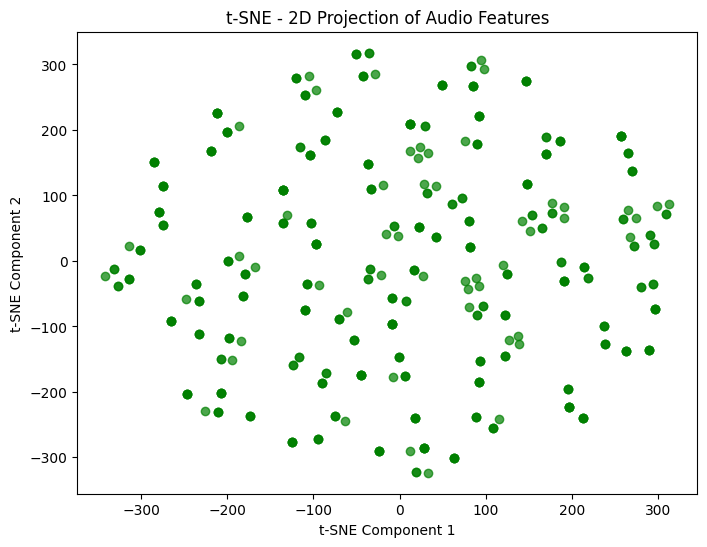

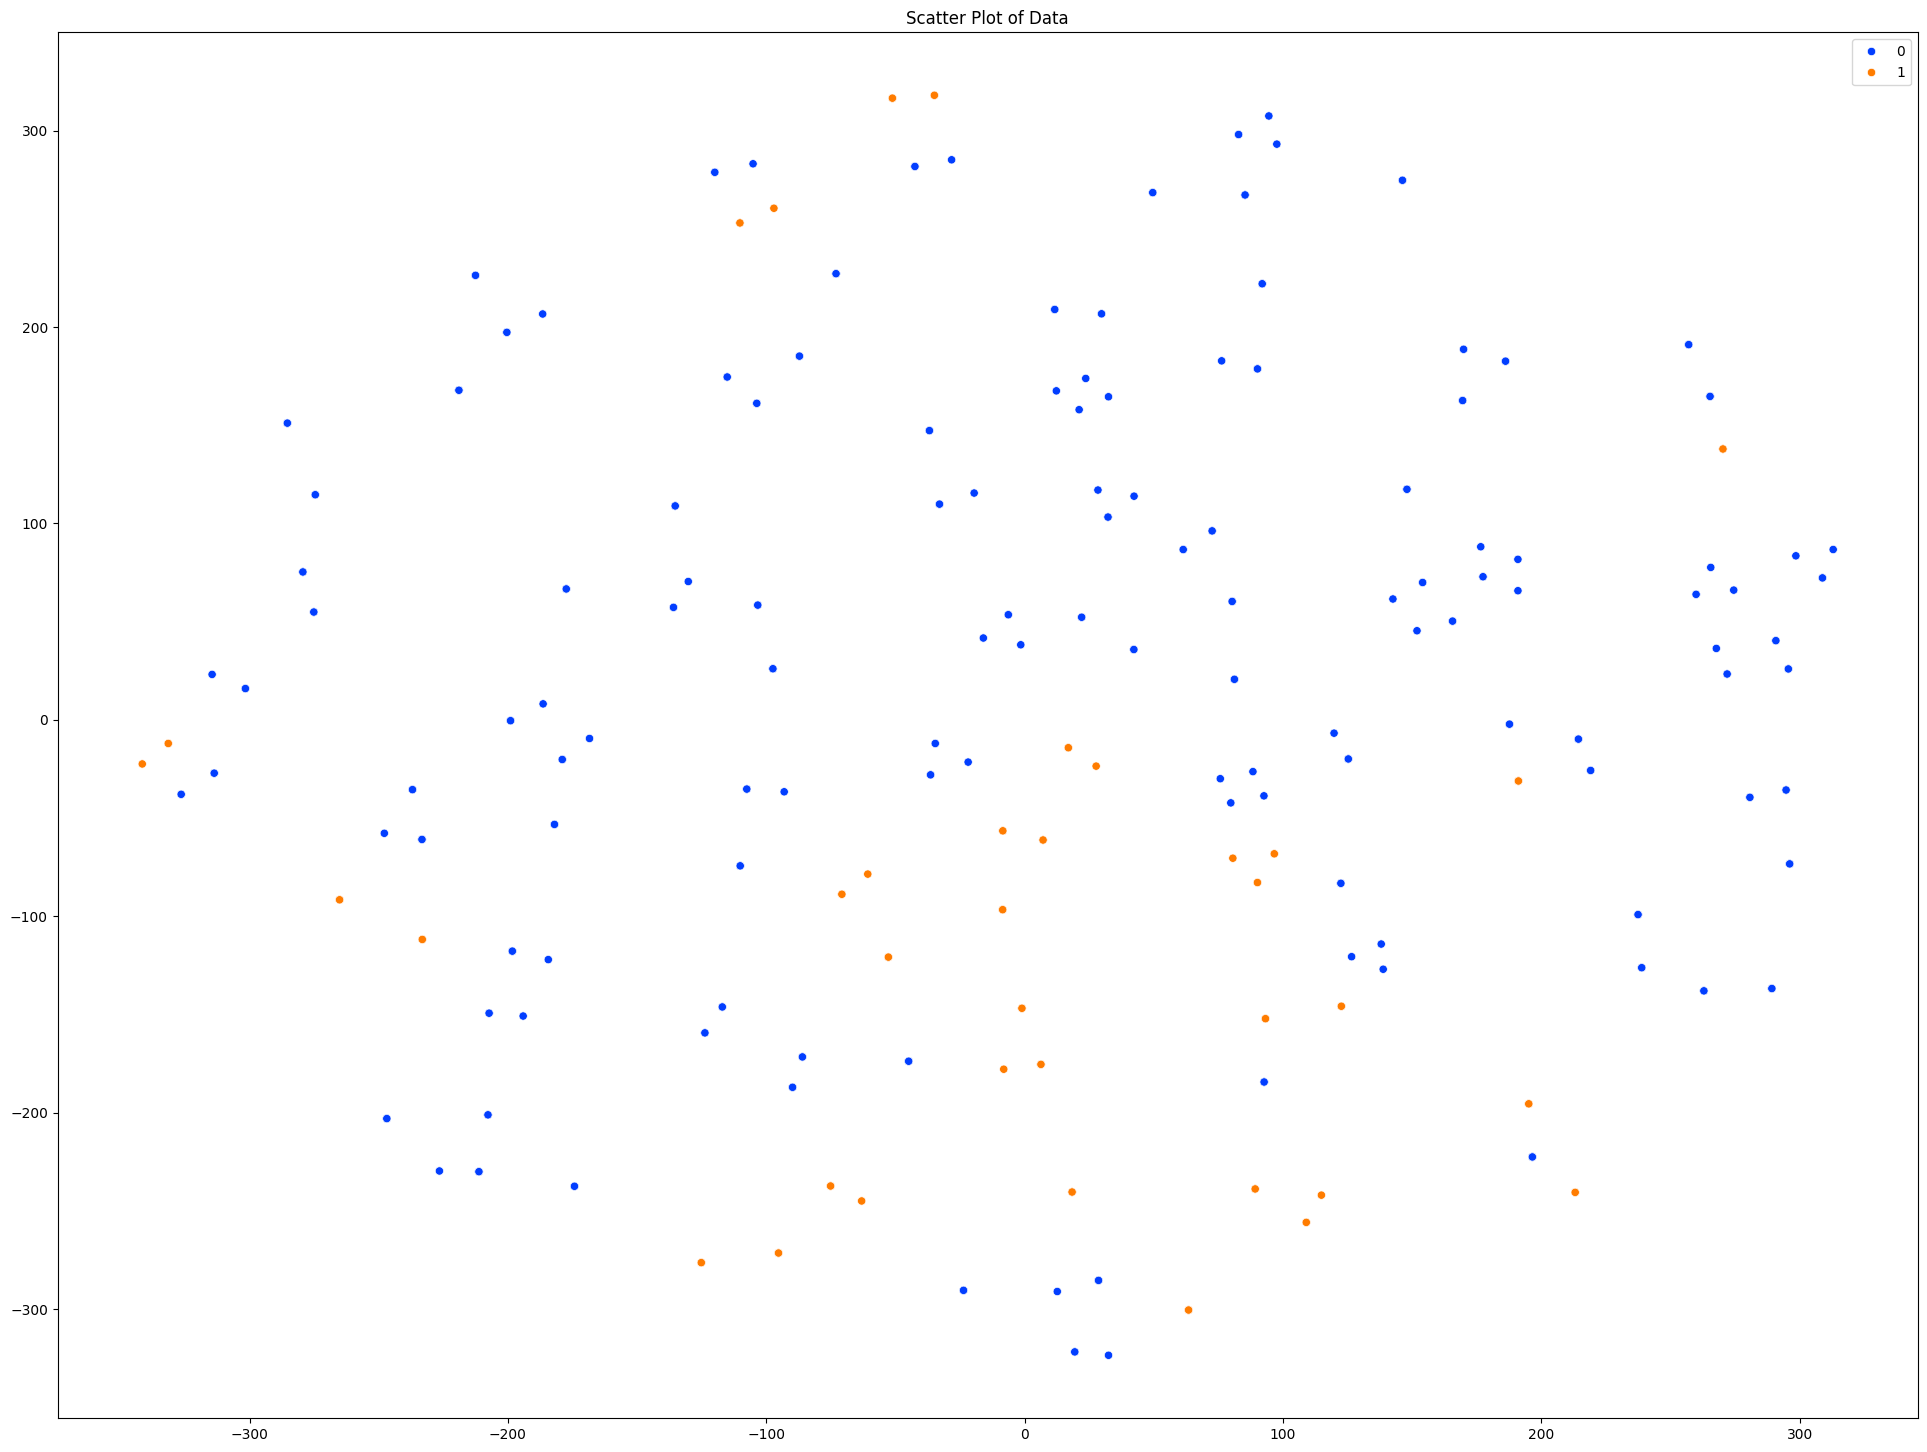

In [53]:
features = np.array(features)
tsne_2d = TSNE(n_components=2, perplexity=10, random_state=42)
features_tsne_2d = tsne_2d.fit_transform(features)

# Plot t-SNE 2D
plt.figure(figsize=(8, 6))
plt.scatter(features_tsne_2d[:, 0], features_tsne_2d[:, 1],alpha=0.7, color="green")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE - 2D Projection of Audio Features")
plt.show()
plt.figure(figsize=(24, 18))
sns.scatterplot(x=features_tsne_2d[:, 0], y=features_tsne_2d[:, 1], hue=gender_labels, palette="bright")
plt.title("Scatter Plot of Data")
plt.show()

AttributeError: PathCollection.set() got an unexpected keyword argument 'z'

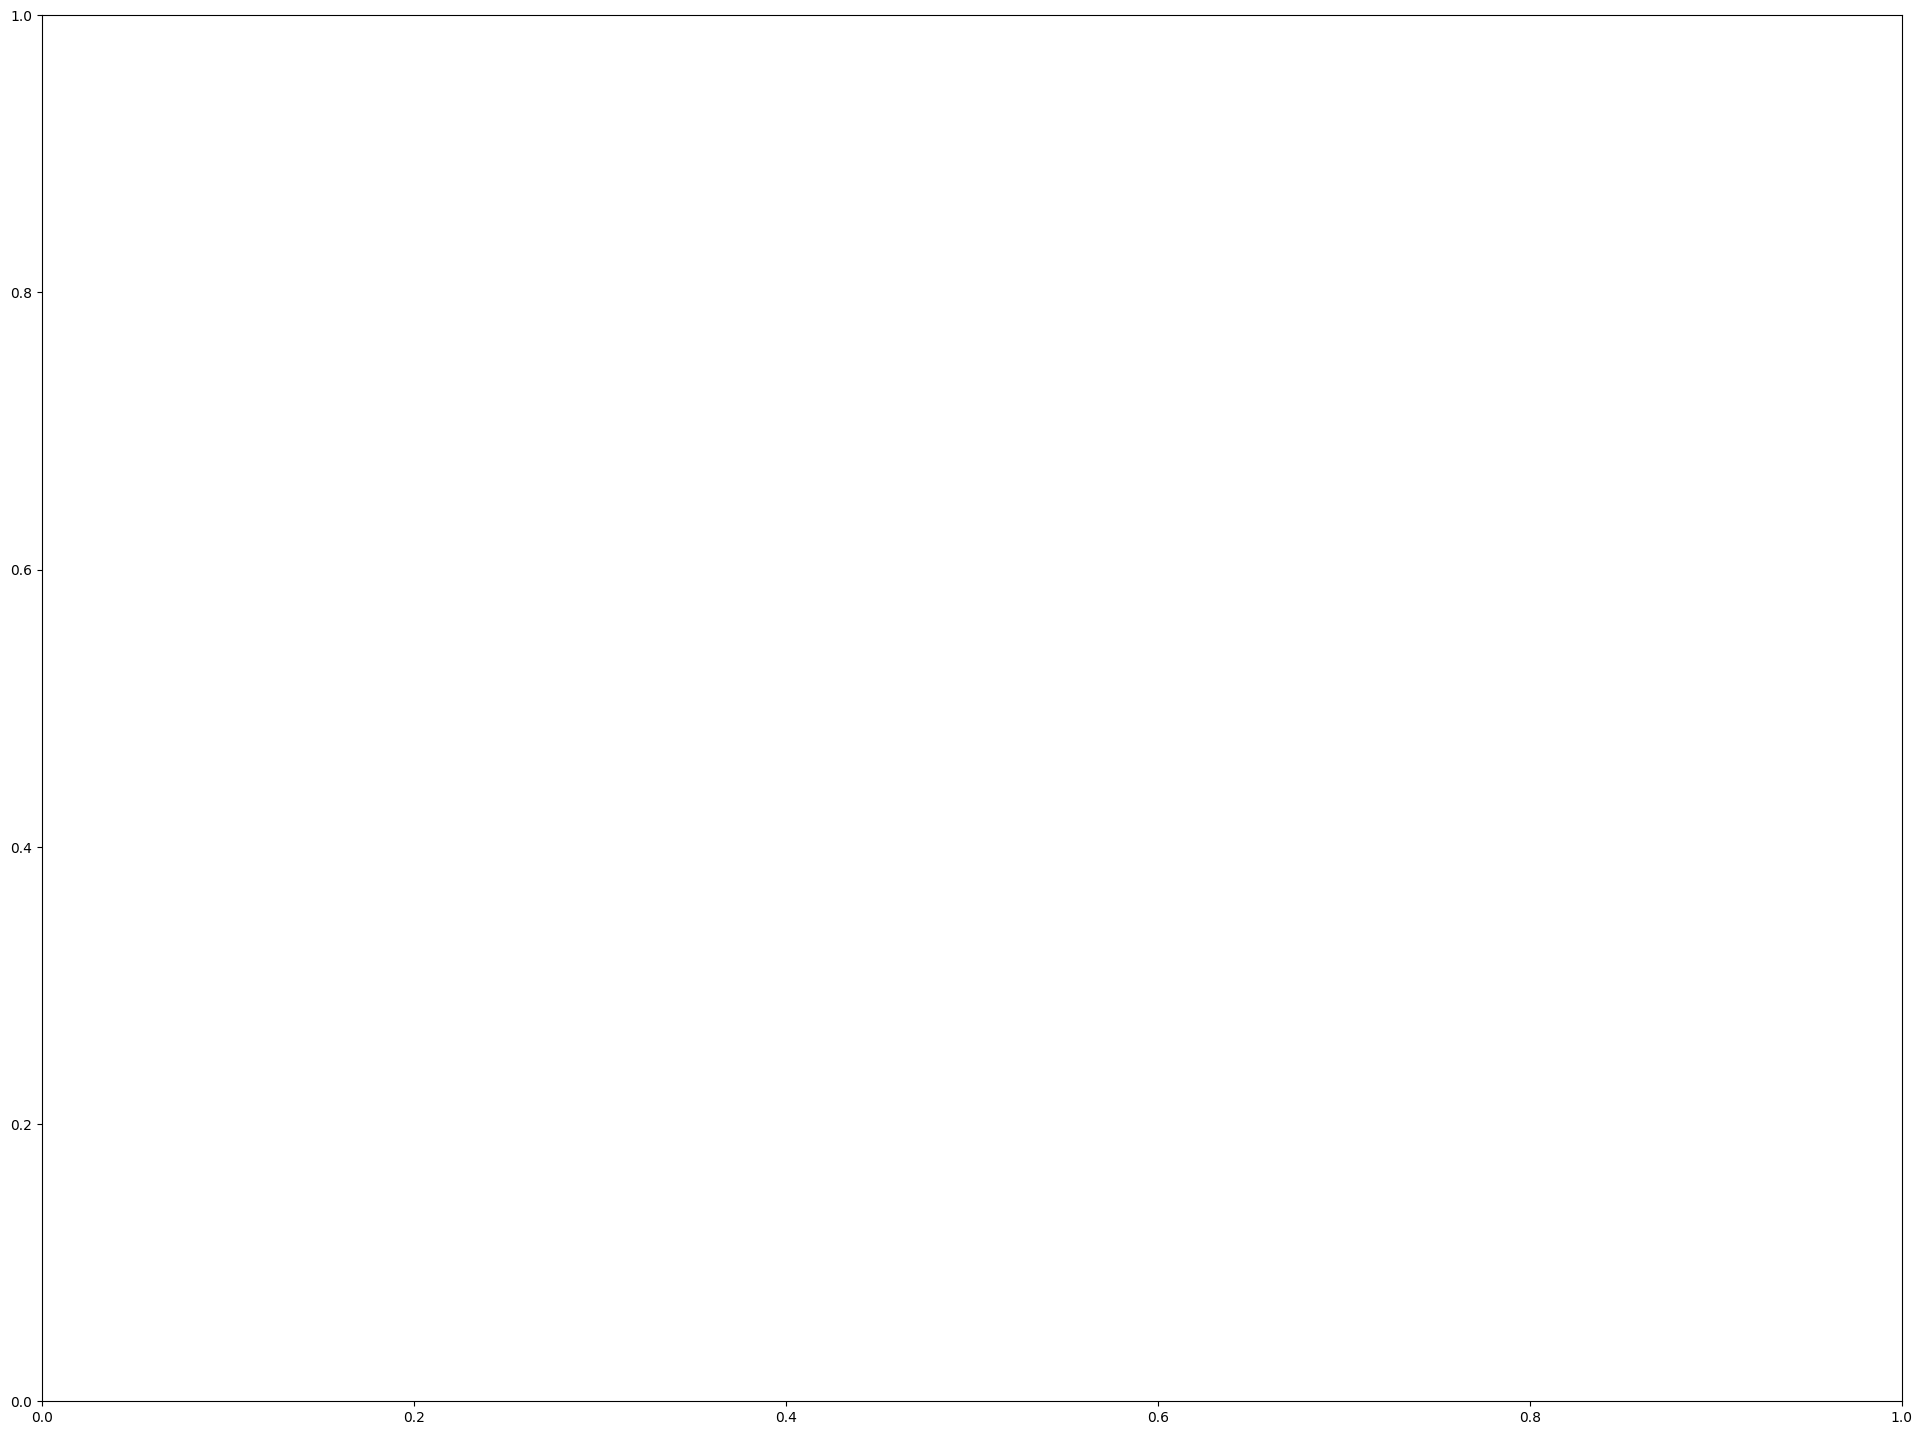

In [55]:
features = np.array(features)
tsne_2d = TSNE(n_components=3, perplexity=10, random_state=42)
features_tsne_2d = tsne_2d.fit_transform(features)
plt.figure(figsize=(24, 18))
sns.scatterplot(x=features_tsne_2d[:, 0], y=features_tsne_2d[:, 1],z = features_tsne_2d[:, 2], hue=gender_labels, palette="bright")
plt.title("Scatter Plot of Data")
plt.show()